<a href="https://colab.research.google.com/github/mhdykz/colorQuantization/blob/ipynbFiles/task3-n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math

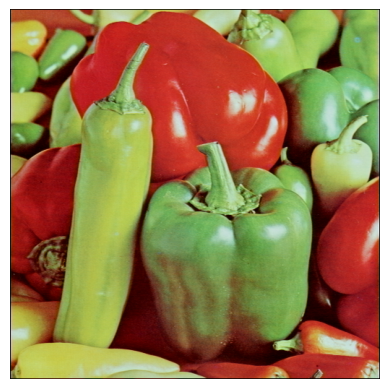

In [8]:
image_path = 'peppers.tif'
image = Image.open(image_path)
image_array = np.array(image)

plt.imshow(image_array)
plt.axis('off')
plt.show()

In [3]:
reshaped_image = image_array.reshape(-1, 3)

print("Type of array:", type(reshaped_image))
print("Shape of array:", reshaped_image.shape)
print("Number of dimensions:", reshaped_image.ndim)

Type of array: <class 'numpy.ndarray'>
Shape of array: (262144, 3)
Number of dimensions: 2


In [9]:
def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def findNearestPointDistance(k_points, points):
    k_points_array = np.array(k_points)
    distances = np.linalg.norm(points[:, np.newaxis] - k_points_array, axis=2)
    return distances.min(axis=1)

def makeKRandomPoints(k, array):
    random_index = np.random.randint(array.shape[0])
    first_point = array[random_index]
    k_points = [first_point]

    for i in range(1, k):
        weight_distance = findNearestPointDistance(k_points, array)
        weight_distance /= weight_distance.sum()
        random_pixel_index = np.random.choice(array.shape[0], p=weight_distance)
        k_points.append(array[random_pixel_index])

    return k_points

k_points = makeKRandomPoints(16, reshaped_image)

In [15]:
def makeCluster(k_points, array):
    clusters = [[] for _ in range(len(k_points))]
    k_points_array = np.array(k_points)

    for point in array:
        distances = np.linalg.norm(k_points_array - point, axis=1)
        min_index = np.argmin(distances)
        clusters[min_index].append(point.tolist())

    return clusters

def move_k_point(k_points, clusters):
    new_k_points = []
    for cluster in clusters:
        if len(cluster) > 0:
            cluster_array = np.array(cluster)
            weights = np.linalg.norm(cluster_array - np.mean(cluster_array, axis=0), axis=1)
            weights = 1 / (weights + 1e-10)
            weighted_mean = np.average(cluster_array, axis=0, weights=weights)
            new_k_points.append(weighted_mean.astype(np.uint8))
        else:
            new_k_points.append(k_points[len(new_k_points)])
    return new_k_points

In [16]:
class MyKMeans:
    def __init__(self, k, max_iter=-1):
        self.k = k
        self.max_iter = max_iter
        self.iterCounter = 0

    def fit(self, array):
        k_points = makeKRandomPoints(self.k, array)
        for _ in range(self.max_iter if self.max_iter != -1 else 100):
            clusters = makeCluster(k_points, array)
            new_k_points = move_k_point(k_points.copy(), clusters)

            if np.array_equal(k_points, new_k_points):
                break

            k_points = new_k_points
            self.iterCounter += 1

        return k_points

k_mean = MyKMeans(16, 100)
k_points = k_mean.fit(reshaped_image)


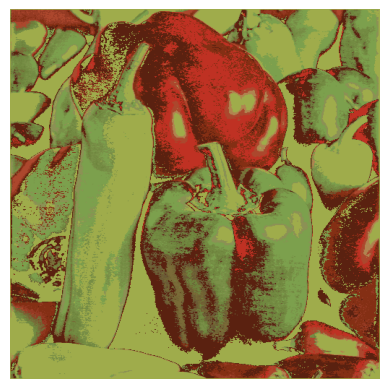

(512, 512, 3)

In [17]:
def replace_colors(image, k_points):
    pixel_array = image.reshape(-1, 3)
    k_points_array = np.array(k_points)
    distances = np.linalg.norm(pixel_array[:, np.newaxis] - k_points_array, axis=2)
    closest_indices = np.argmin(distances, axis=1)
    quantized_pixels = k_points_array[closest_indices]
    quantized_image = quantized_pixels.reshape(image.shape)
    return quantized_image

final_image = replace_colors(image_array, k_points)
plt.imshow(final_image)
plt.axis('off')
plt.show()

final_image.shape